In [43]:
# Packages

import os
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import stanza
from datetime import datetime as dt
import re
from itertools import compress
import ast

#stanza.download('da')

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

#data_path = os.path.join('C:/', 'data', 'horesta')
data_path = os.path.join('D:/', 'data', 'horesta')
out_path = os.path.join('..', 'output')

2021-02-19 10:52:56 INFO: Downloading default packages for language: da (Danish)...
2021-02-19 10:53:28 INFO: Finished downloading models and saved to C:\Users\kgk\stanza_resources.


In [38]:
# Loading data
path = os.path.join(data_path, 'horesta_posts_2021-02-02.json')

with open(path, 'r') as file:
    data = json.load(file)
    
len(data)

1261

In [39]:
# Converting data to data frame

df = pd.DataFrame.from_records(data)

In [6]:
# Exporting data as csv

filename = 'horesta_posts_{}.csv'.format(str(dt.now().date()))
df_select = df.loc[:, df.columns != 'html']
df_select['text'] = df_select['text'].apply(lambda string: string.replace("\n", ""))
df_select.to_csv(os.path.join(data_path, filename), index = False)

C:\Users\kgk\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [37]:
# Exporting texts

df_export = df.copy()
df_export['publish_date'] = df_export['publish_date'].str.replace(' ', '')
df_export['text'] = df_export['title'] + df_export['text']

outdir = os.path.join(data_path, 'txt')
old_postdate = ""
counter = 1

for postindex in list(df_export.index):
    postdate = df_export.loc[postindex, 'publish_date']
    
    year = postdate[6:10]
    month = postdate[3:5]
    day = postdate[0:2]
    
    postdate = year + "-" + month + "-" + day
    
    indexstr = str(postindex).rjust(4, '0')
        
    filename = "horesta_{date}_{index}.txt".format(date = postdate, index = indexstr)
    
    old_postdate = postdate

    outpath = os.path.join(outdir, filename)

    with open(outpath, 'w', encoding = "utf-8") as f:
        f.write(str(df_export.loc[postindex, 'text']))

In [25]:
# Adding date variables

df['publish_date'] = pd.to_datetime(df['publish_date'], format = '%d-%m - %Y')
df['post_month'] = df['publish_date'].dt.month
df['post_year'] = df['publish_date'].dt.year
df['year_month'] = df['publish_date'].apply(lambda x: str(x)[0:7])

In [26]:
# Creating tidy format for tags
df_long = df.explode('tags').reset_index()
df_long['tags'] = df_long['tags'].str.lower() # Convert to lowercase

In [27]:
df_long.head()

,index,url,accessed,title,tags,links,publish_date,access_date,text,html,post_month,post_year,year_month
0,0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,coronakrise,[],2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...",12,2020,2020-12
1,0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,horesta,[],2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...",12,2020,2020-12
2,0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,kirsten munch,[],2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...",12,2020,2020-12
3,0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,vaccination,[],2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...",12,2020,2020-12
4,0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,hurtigtest,[],2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...",12,2020,2020-12


In [28]:
# Top tags 

print(df_long['tags'].value_counts()[0:10])

top_tags = list(df_long['tags'].value_counts().index[0:10]) # Top tags as list
df_filter = df_long.loc[df_long['tags'].isin(top_tags), :] # Data filtered for top tags

politik                   289
hotel                     228
restaurant                201
turisme                   191
covid-19                  159
økonomi                   142
katia k. østergaard       103
horesta                    98
jura                       91
kirsten munch andersen     79
Name: tags, dtype: int64


In [29]:
# Counting tags - monthly

df_grouped = df_filter.groupby(['year_month', 'tags']) # Grouping
df_timecount = df_grouped.size().to_frame(name = 'count').reset_index() # Counting

df_timecount.head()

,year_month,tags,count
0,2018-04,turisme,1
1,2018-06,horesta,2
2,2018-06,hotel,3
3,2018-06,jura,2
4,2018-06,katia k. østergaard,3


In [30]:
# Exporting csv

filename = "horesta-posts_top10-monthly.csv"
df_timecount.to_csv(os.path.join(out_path, filename), index = False)

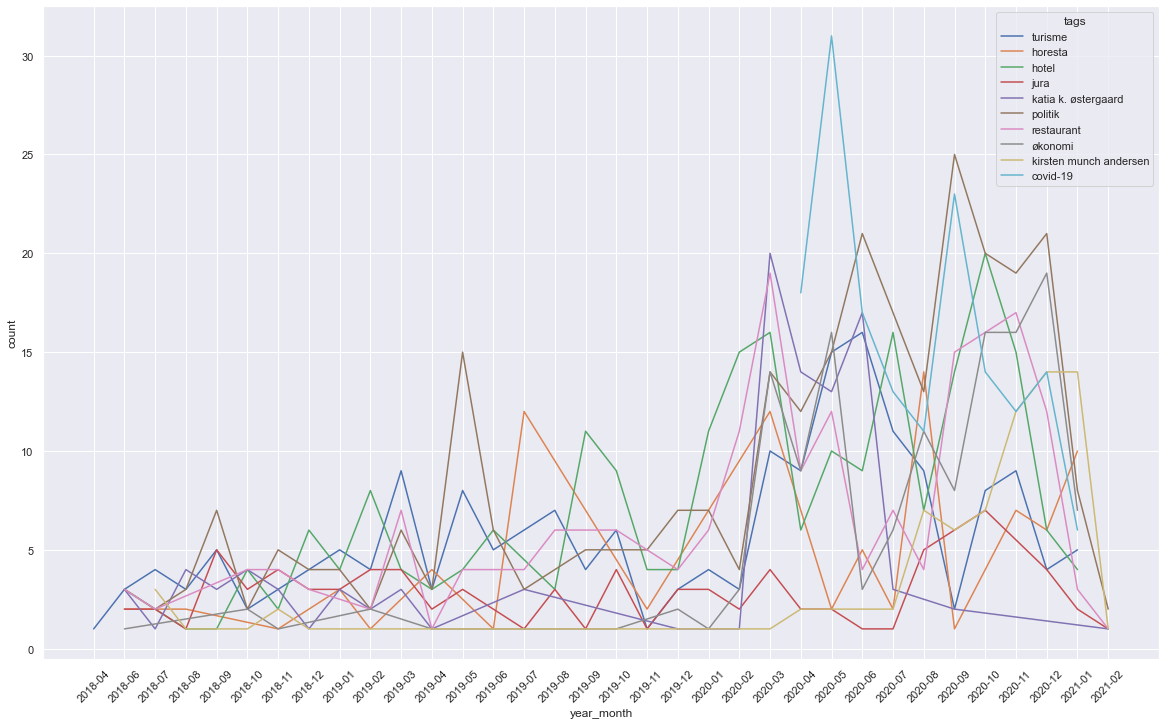

In [31]:
# Visualizing use of top tags over time

sns.lineplot(data = df_timecount, x = 'year_month', y = 'count', hue = 'tags')
plt.xticks(rotation = 45)
plt.show()

In [78]:
# Processing text

nlp = stanza.Pipeline('da', processors = 'tokenize,pos')

2021-02-12 12:37:32 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |

2021-02-12 12:37:32 INFO: Use device: cpu
2021-02-12 12:37:32 INFO: Loading: tokenize
2021-02-12 12:37:32 INFO: Loading: pos
2021-02-12 12:37:33 INFO: Done loading processors!


In [193]:
def tokenizer_custom(text):
    doc = nlp(text)
        
    pos_tags = ['NOUN'] # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.pos in pos_tags:
                token = word.text.lower() # Returning the word in lower-case.
                tokens.append(token)
    
    return(tokens)

In [194]:
df['tokens'] = df['text'].apply(tokenizer_custom)

In [195]:
df.head()

,url,accessed,title,tags,links,publish_date,access_date,text,html,tokens
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",[],04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...","[måned, udrulningen, vaccinationsprogram, håb,..."
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",[],04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...","[behov, oplevelsesøkonomiens, konkurrencekraft..."
2,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",[],03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...","[flertal, ugers, feriepenge, pengene, marts, t..."
3,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...","[/webinar-med-danske-bank, /cdn-cgi/l/email-pr...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...","[danskernes, forbrugsvaner, coronakrisen, forb..."
4,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",[/events/2020/december/webinar-med-vaekstfonde...,02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"\n<!DOCTYPE html>\n\n<html lang=""da"">\n<head>\...","[webinar, tirsdag, december, vækstfonden, netv..."


In [196]:
import math

df_long = df.explode('tokens')
termoccur = df_long.groupby(['url', 'tokens']).size().to_frame(name = "termcount")
dococcur = termoccur.reset_index().groupby(['tokens']).size().to_frame(name = "doccount")

df_merge = termoccur.join(dococcur, on = 'tokens')
df_merge['idf'] = df_merge['doccount'].apply(lambda count: math.log(df.shape[0] +1 / count +1 )) + 1
df_merge['idf_sqrt'] = df_merge['idf'].apply(lambda x: math.sqrt(x))

trueidf = df_merge.groupby(['url'])

sumidf = trueidf['idf_sqrt'].sum().to_frame(name = 'idfsum')
df_merge = df_merge.join(sumidf, on = 'url')
df_merge['tfidf'] = df_merge['termcount'] * (df_merge['idf'] / np.sqrt(df_merge['idfsum']))
df_merge = df_merge.reset_index().sort_values('tfidf', ascending = False)

In [201]:
df_terms = df_merge.groupby('tokens')['tfidf'].sum().to_frame(name = "tfidf_sum").sort_values('tfidf_sum', ascending = False).reset_index()

In [207]:
filter_terms = ['år', 'tlf', 'pct.', 'dag', 'brug', 'kr.', 'kl.', 'del', 'række', 'tid', 'fokus', 'gang', 'forhold', 'procent', 'eksempel', 'antallet', '”']

In [208]:
df_terms = df_terms.loc[~df_terms['tokens'].isin(filter_terms), :]

In [ ]:
# https://textacy.readthedocs.io/en/stable/_modules/textacy/text_utils.html#keyword_in_context

In [347]:
nlp = stanza.Pipeline('da', processors = 'tokenize')

def simple_tokenizer(text):
    
    punct_re = re.compile(r'\.|\,|\!|\?|\;|\s–|\”')
    
    text = re.sub(punct_re, '', text)
    
    doc = nlp(text)
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            token = word.text
            tokens.append(token)
    
    return(tokens)

2021-02-19 15:10:58 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |

2021-02-19 15:10:58 INFO: Use device: cpu
2021-02-19 15:10:58 INFO: Loading: tokenize
2021-02-19 15:10:58 INFO: Done loading processors!


In [348]:
df_conc = df.copy()
df_conc = df_conc.loc[:, df_conc.columns != "html"]
df_conc['text'] = df_conc['text'].str.split('.')
df_conc = df_conc.explode('text')
df_conc['tokens'] = df_conc['text'].apply(simple_tokenizer)

In [349]:
keywords = ['virksomhed', 'hotel', 'restaurant', 'erhverv']

def keyword_check(keywords, text):
    
    matches = list(compress(keywords, [re.compile(r'.*\b{}.*'.format(keyword), re.IGNORECASE).match(text, re.DOTALL) for keyword in keywords]))
    
    return(matches)

keyword_check(keywords, str(df.loc[0, 'text']))

['erhverv']

In [350]:
df_conc['keywords'] = df_conc['text'].apply(lambda text: keyword_check(keywords, text))

In [351]:
df_conc.tail()

,url,accessed,title,tags,links,publish_date,access_date,text,tokens,keywords
1260,https://horesta.dk/nyheder/2020/december/kom-p...,1,Kom på webinar om nye og forlængede restriktioner,"[webinar, jura, politik]","[#, tel:+4535248004, /cdn-cgi/l/email-protecti...",08-12 - 2020,2021-02-02,\nWebinaret er forbeholdt medlemmer af HORESTA...,"[Webinaret, er, forbeholdt, medlemmer, af, HOR...",[]
1260,https://horesta.dk/nyheder/2020/december/kom-p...,1,Kom på webinar om nye og forlængede restriktioner,"[webinar, jura, politik]","[#, tel:+4535248004, /cdn-cgi/l/email-protecti...",08-12 - 2020,2021-02-02,+45 35 24 80 04 \n\n\n[email protected]\n\n\n...,"[+, 45, 35, 24, 80, 04, [email, protected], He...",[]
1260,https://horesta.dk/nyheder/2020/december/kom-p...,1,Kom på webinar om nye og forlængede restriktioner,"[webinar, jura, politik]","[#, tel:+4535248004, /cdn-cgi/l/email-protecti...",08-12 - 2020,2021-02-02,+45 35 24 80 45\n\n\n[email protected]\n\n\n\...,"[+, 45, 35, 24, 80, 45, [email, protected], He...",[]
1260,https://horesta.dk/nyheder/2020/december/kom-p...,1,Kom på webinar om nye og forlængede restriktioner,"[webinar, jura, politik]","[#, tel:+4535248004, /cdn-cgi/l/email-protecti...",08-12 - 2020,2021-02-02,Voss\n\n\nTlf,"[Voss, Tlf]",[]
1260,https://horesta.dk/nyheder/2020/december/kom-p...,1,Kom på webinar om nye og forlængede restriktioner,"[webinar, jura, politik]","[#, tel:+4535248004, /cdn-cgi/l/email-protecti...",08-12 - 2020,2021-02-02,+45 35 24 80 41 \n\n\n[email protected]\n\n\n...,"[+, 45, 35, 24, 80, 41, [email, protected], He...",[]


In [353]:
df_conc = df_conc.explode('keywords')
df_conc = df_conc.dropna(subset = ['keywords']).reset_index(drop = True)

In [354]:
df_conc.head()

,url,accessed,title,tags,links,publish_date,access_date,text,tokens,keywords
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",[],04-12 - 2020,2020-12-04,"Men retningen er den rigtige, og dermed skabe...","[Men, retningen, er, den, rigtige, og, dermed,...",erhverv
1,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",[],04-12 - 2020,2020-12-04,"En plan, som kan gøre det muligt for vores er...","[En, plan, som, kan, gøre, det, muligt, for, v...",erhverv
2,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",[],04-12 - 2020,2020-12-04,"\nSådan lød meldingen, da Small Danish Hotels ...","[Sådan, lød, meldingen, da, Small, Danish, Hot...",hotel
3,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",[],04-12 - 2020,2020-12-04,"\nSådan lød meldingen, da Small Danish Hotels ...","[Sådan, lød, meldingen, da, Small, Danish, Hot...",erhverv
4,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",[],04-12 - 2020,2020-12-04,"I forvejen har 2020 været et katastrofeår, så...","[I, forvejen, har, 2020, været, et, katastrofe...",hotel


In [355]:
def get_concs(url, kw, tokens, context = 5):
    
    locs = []
    
    for c, token in enumerate(tokens):
        if re.compile(r'.*\b{}.*'.format(kw), re.IGNORECASE).match(token):
            locs.append(c)
    
    concs = []
    
    for loc in locs:
        
        concdict = {}
        
        lb = loc - context

        if lb < 0:
            lb = 0

        ub = loc + (context + 1)

        if ub >= len(tokens):
            ub = len(tokens)
        
        kw_offset = loc - lb
        
        conc = [''] * 11
        
        conctokens = tokens[lb:ub]
        
        concind = 0
        for i in range(0, 11):
            if i + kw_offset < 5:
                continue
            conc[i] = conctokens[concind]
            concind = concind + 1
            if concind > len(conctokens)-1:
                break
        
        kw_offset = loc - lb
        
        concdict['url'] = url
        concdict['keyword'] = kw
        concdict['conc'] = conc
        concdict['kw-pos'] = kw_offset
                    
        concs.append(concdict)
    
    return(concs)

In [356]:
all_concs = []

for row in df_conc.index:
    row_url = df_conc.loc[row, 'url']
    row_kw = df_conc.loc[row, 'keywords']
    row_tokens = df_conc.loc[row, 'tokens']
    
    concs = get_concs(row_url, row_kw, row_tokens, context = 5)
    
    all_concs = all_concs + concs

In [357]:
concsdf = pd.DataFrame.from_records(all_concs)

In [358]:
concsdf.head()

,url,keyword,conc,kw-pos
0,https://horesta.dk/nyheder/2020/december/det-e...,erhverv,"[planlægge, hvordan, og, hvornår, vores, erhve...",5
1,https://horesta.dk/nyheder/2020/december/det-e...,erhverv,"[gøre, det, muligt, for, vores, erhverv, at, t...",5
2,https://horesta.dk/nyheder/2020/december/forsl...,hotel,"[lød, meldingen, da, Small, Danish, Hotels, i,...",5
3,https://horesta.dk/nyheder/2020/december/forsl...,erhverv,"[går, havde, foretræde, for, Folketingets, Erh...",5
4,https://horesta.dk/nyheder/2020/december/forsl...,hotel,"[siger, direktør, i, Small, Danish, Hotels, Jø...",5


In [359]:
new_cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for col in new_cols:
    concsdf[col] = concsdf['conc'].apply(lambda tokens: tokens[col])

In [360]:
concsdf.head()

,url,keyword,conc,kw-pos,0,1,2,3,4,5,6,7,8,9,10
0,https://horesta.dk/nyheder/2020/december/det-e...,erhverv,"[planlægge, hvordan, og, hvornår, vores, erhve...",5,planlægge,hvordan,og,hvornår,vores,erhverv,kan,begynde,at,skabe,omsætning
1,https://horesta.dk/nyheder/2020/december/det-e...,erhverv,"[gøre, det, muligt, for, vores, erhverv, at, t...",5,gøre,det,muligt,for,vores,erhverv,at,tænde,for,det,lange
2,https://horesta.dk/nyheder/2020/december/forsl...,hotel,"[lød, meldingen, da, Small, Danish, Hotels, i,...",5,lød,meldingen,da,Small,Danish,Hotels,i,går,havde,foretræde,for
3,https://horesta.dk/nyheder/2020/december/forsl...,erhverv,"[går, havde, foretræde, for, Folketingets, Erh...",5,går,havde,foretræde,for,Folketingets,Erhvervsudvalg,og,organisationen,havde,konkrete,forslag
4,https://horesta.dk/nyheder/2020/december/forsl...,hotel,"[siger, direktør, i, Small, Danish, Hotels, Jø...",5,siger,direktør,i,Small,Danish,Hotels,Jørgen,Christensen,der,var,med


In [361]:
# save data

savepath = os.path.join(data_path, 'work', 'horesta_concordance.csv')

concsdf.to_csv(savepath)

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

texts = list(df['text'])

vectorizer = TfidfVectorizer()
tfidf_m = vectorizer.fit_transform(texts)

features = vectorizer.get_feature_names()

tfidf_df = pd.DataFrame(vectorizer.idf_, index = features)
tfidf_df = tfidf_df.sort_values(0, ascending = False)
tfidf_df.head(50)

,0
ﬂest,7.447306
holte,7.447306
holdningerne,7.447306
holdningsændring,7.447306
holdspillere,7.447306
rejseplanlægningsfaser,7.447306
rejseplaner,7.447306
holdånd,7.447306
holdøvelser,7.447306
holistisk,7.447306


In [ ]:
# tf-idf
## tf: term occurence in document
## idf: log(N (total documents) / number of documents term appears in)

In [3]:
import math

math.log(10)

2.302585092994046

In [132]:
lectures = ["this is some food food", "this is some drink"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lectures)
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 2
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['food', 'drink']
